In [1]:
import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

train_scaled = X_train/ 255.0
X_train, X_val = train_test_split(
    train_scaled, test_size = 0.2, random_state = 42)   

In [2]:
# Encoding 에서 잠재변수를 샘플링하는 사용자 정의 층
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


In [10]:
# encoder

codings_size = 10

inputs = keras.layers.Input(shape = [28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation = 'selu')(z)
z = keras.layers.Dense(100, activation = 'selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

# 모델의 출력은 Sampling을 
variational_encoder = keras.Model(
    inputs = [inputs], outputs = [codings])

In [11]:
variational_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 150)          117750      ['flatten_1[0][0]']              
                                                                                                  
 dense_8 (Dense)                (None, 100)          15100       ['dense_7[0][0]']                
                                                                                            

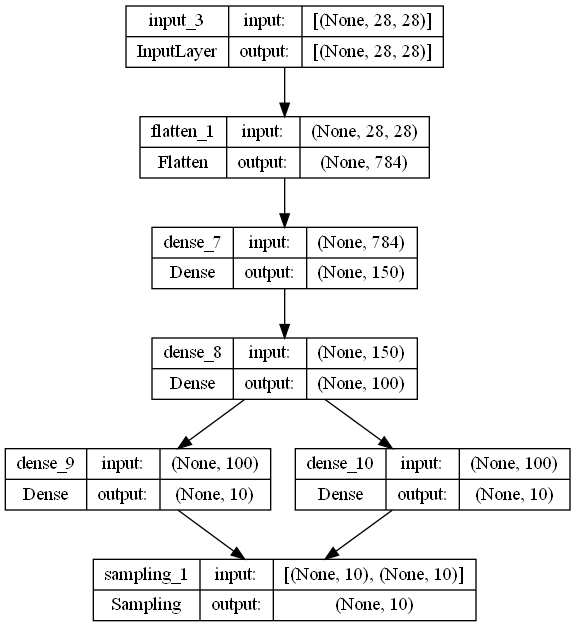

In [48]:
plot_model(variational_encoder, show_shapes=True, show_layer_names=True)

In [12]:
# decoder

decoder_inputs = keras.layers.Input(shape = [codings_size])
x = keras.layers.Dense(100, activation = 'selu')(decoder_inputs)
x = keras.layers.Dense(150, activation = 'selu')(x)
x = keras.layers.Dense(28 * 28, activation = 'sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

In [6]:
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 150)               15150     
                                                                 
 dense_6 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


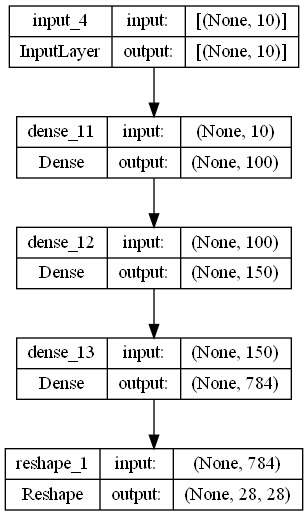

In [49]:
plot_model(variational_decoder, show_shapes=True, show_layer_names=True)

In [13]:
# VAE 
codings = variational_encoder(inputs)

reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs = [inputs], outputs = [reconstructions])


# Regularization
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)

latent_loss = tf.reduce_mean(latent_loss) / 784

# Binary cross-entropy loss calculation
reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(reconstructions))

# Total loss definition (ELBO)
total_loss = reconstruction_loss + latent_loss

variational_ae.add_loss(total_loss)
variational_ae.compile(optimizer='rmsprop')

In [14]:
variational_ae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model_3 (Functional)           (None, 10)           134870      ['input_3[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 28, 28)       134634      ['model_3[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                            

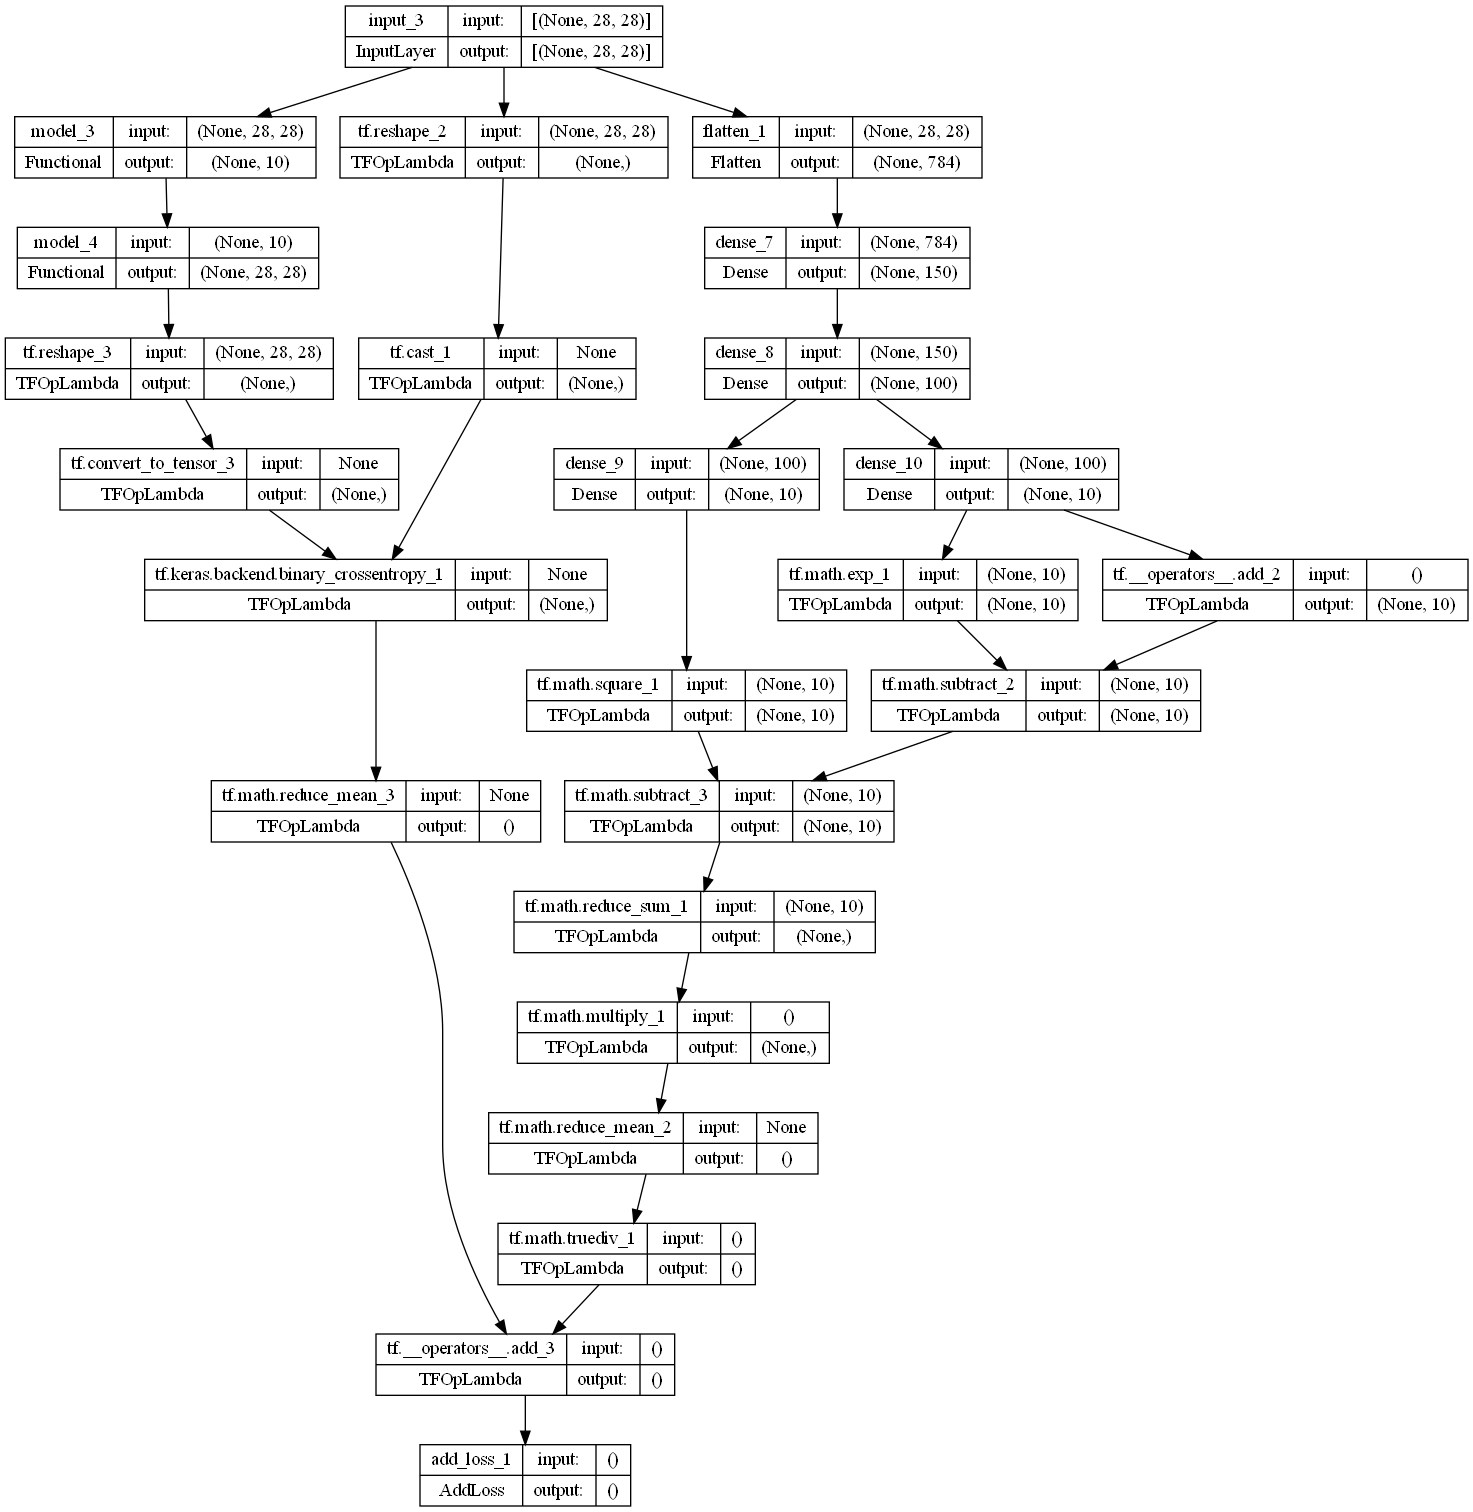

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(variational_ae, show_shapes=True, show_layer_names=True)

In [40]:
history = variational_ae.fit(X_train, X_train, epochs = 100 , batch_size = 128, validation_data = (X_val, X_val))


Epoch 1/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1431 - val_loss: 0.1434
Epoch 2/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1428 - val_loss: 0.1438
Epoch 3/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1428 - val_loss: 0.1424
Epoch 4/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1426 - val_loss: 0.1433
Epoch 5/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1424 - val_loss: 0.1431
Epoch 6/100
375/375 [==============================] - 3s 9ms/step - loss: 0.1423 - val_loss: 0.1426
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1422 - val_loss: 0.1425
Epoch 8/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1420 - val_loss: 0.1427
Epoch 9/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1418 - val_loss: 0.1425
Epoch 10/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1417

375/375 [==============================] - 4s 11ms/step - loss: 0.1360 - val_loss: 0.1370
Epoch 81/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1359 - val_loss: 0.1367
Epoch 82/100
375/375 [==============================] - 4s 12ms/step - loss: 0.1358 - val_loss: 0.1371
Epoch 83/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1358 - val_loss: 0.1368
Epoch 84/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1358 - val_loss: 0.1379
Epoch 85/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1357 - val_loss: 0.1364
Epoch 86/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1356 - val_loss: 0.1366
Epoch 87/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1356 - val_loss: 0.1367
Epoch 88/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1355 - val_loss: 0.1364
Epoch 89/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1356 - 

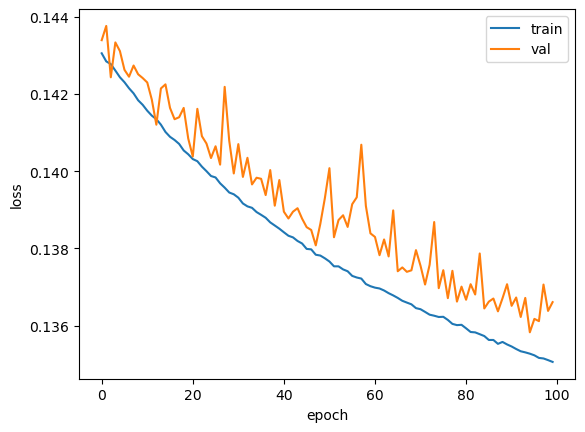

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [72]:
import numpy as np

# X_test에서 임의의 이미지 선택 (예: 첫 5개 이미지)
sample_images = X_test[:5]

# 선택된 이미지를 VAE 모델을 통해 잠재 공간으로 인코딩
encoded_samples = variational_encoder.predict(sample_images)

1/1 [==============================] - 0s 61ms/step


In [73]:
# 잠재 공간에서 무작위 샘플 생성
random_samples = np.random.normal(0, 1, size=(5, codings_size)) # codings_size는 잠재 공간의 차원

# 생성된 샘플을 VAE 모델을 통해 디코딩
decoded_samples = variational_decoder.predict(random_samples)

1/1 [==============================] - 0s 29ms/step


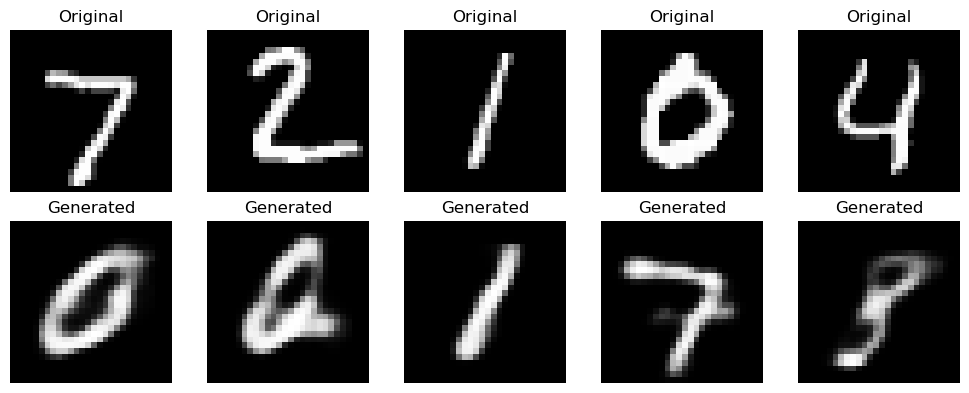

In [74]:
import matplotlib.pyplot as plt

# 원본 이미지와 생성된 이미지를 비교하여 시각화
plt.figure(figsize=(10, 4))
for i in range(5):
    # 원본 이미지
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # 생성된 이미지
    plt.subplot(2, 5, i+6)
    plt.imshow(decoded_samples[i].reshape(28, 28), cmap='gray')
    plt.title("Generated")
    plt.axis('off')

plt.tight_layout()
plt.show()